In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import joblib
from data_augmentation import Data

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import zscore


Error: Unable to load the image from the provided path.


In [3]:
def reload_df(number:str=""):
    return pd.read_csv(f'data_/cleaned_data{number}.csv')
reload_df()

,Time,Res_Freq,Amplitude,Phase,Sample_number,Peak,Before_compression,After_compression,Compression_ratio,Compression_time
0,21.950255,1362.840700,11.808,-4.69,15,0,15.32,12.50,1.225600,9.699554
1,6.049346,1362.979802,11.770,-5.06,15,0,15.32,12.50,1.225600,9.699554
2,21.050204,1363.001243,11.802,-4.92,15,0,15.32,12.50,1.225600,9.699554
3,0.250014,1363.386348,11.766,-4.90,16,0,15.82,12.66,1.249605,12.352707
4,19.450112,1363.397080,11.778,-4.85,16,0,15.82,12.66,1.249605,12.352707
...,...,...,...,...,...,...,...,...,...,...
9481,553.650667,4037.761505,20.596,-2.56,8,1,13.99,11.20,1.249107,239.099676
9482,553.450656,4038.081000,14.494,-7.76,8,1,13.99,11.20,1.249107,239.099676
9483,553.250644,4038.368499,20.678,1.40,8,1,13.99,11.20,1.249107,239.099676
9484,553.350650,4039.194450,17.476,-2.26,8,1,13.99,11.20,1.249107,239.099676


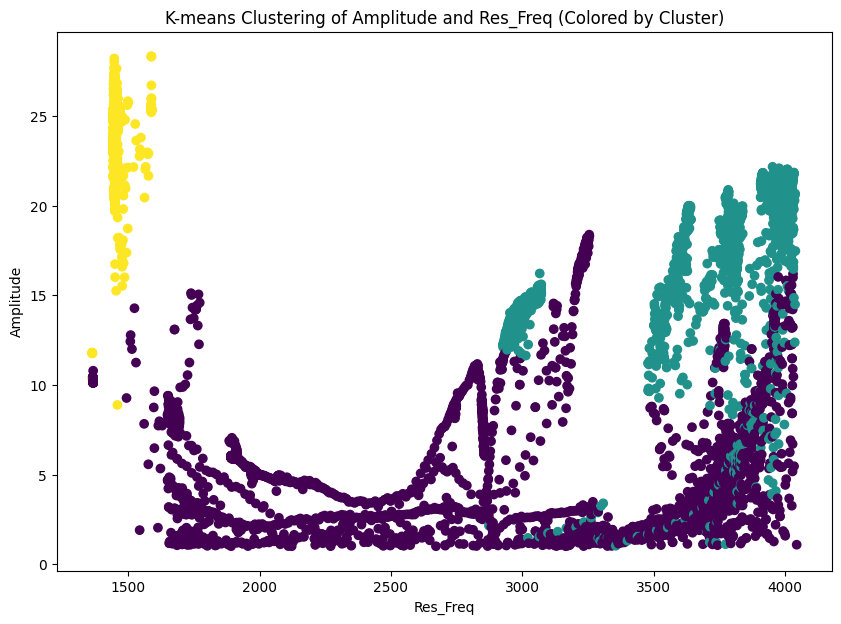

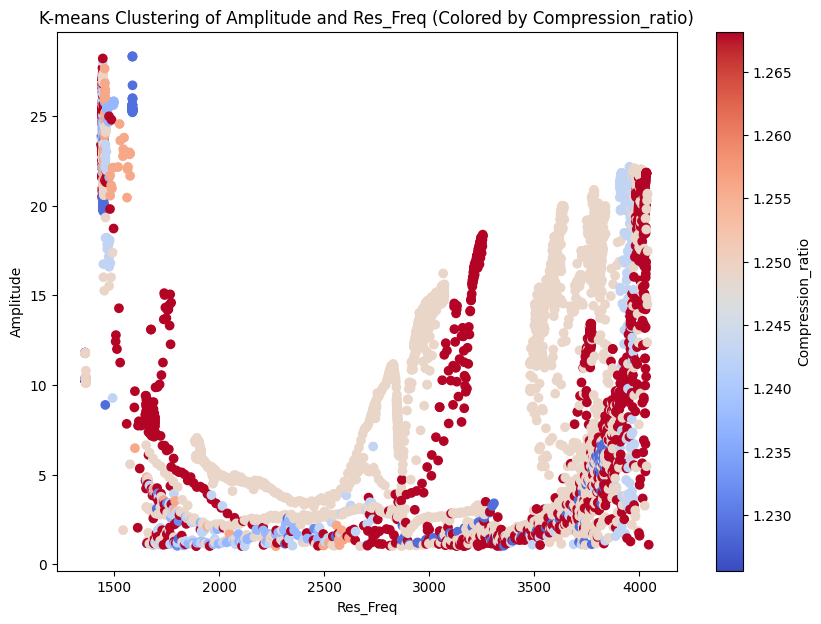

In [4]:
df = reload_df()
# Select the features for clustering
selected_features = ["Amplitude", "Res_Freq", "Compression_ratio"]
X = df[selected_features]

# Standardize the features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering with K=3 (you can choose the appropriate K based on your data)
kmeans = KMeans(n_clusters=3, random_state=55,  n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the DataFrame
df['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X['Res_Freq'], X['Amplitude'], c=clusters, cmap='viridis')
plt.xlabel('Res_Freq')
plt.ylabel('Amplitude')
plt.title('K-means Clustering of Amplitude and Res_Freq (Colored by Cluster)')
plt.show()

# Visualize the clusters with respect to Compression_ratio
plt.figure(figsize=(10, 7))
plt.scatter(X['Res_Freq'], X['Amplitude'], c=df['Compression_ratio'], cmap='coolwarm')
plt.xlabel('Res_Freq')
plt.ylabel('Amplitude')
plt.colorbar(label='Compression_ratio')
plt.title('K-means Clustering of Amplitude and Res_Freq (Colored by Compression_ratio)')
plt.show()



In [5]:
# correlation_res_freq = df_selected["Compression_time"].corr(df_selected["Res_Freq"])
# correlation_amplitude = df_selected["Compression_time"].corr(df_selected["Amplitude"])

# print(f"Correlation between Compression_time and Res_Freq: {correlation_res_freq}")
# print(f"Correlation between Compression_time and Amplitude: {correlation_amplitude}")

# """Positive correlation values close to 1 indicate a positive relationship, while negative correlation values close to -1 indicate a negative relationship.
# Values close to 0 suggest little to no linear relationship."""

Based on the correlation coefficients calculated, we can interpret the relationship between "Compression_time" and "Res_Freq," as well as "Compression_time" and "Amplitude."

    Correlation between Compression_time and Res_Freq: 0.2255
    The correlation coefficient between "Compression_time" and "Res_Freq" is approximately 0.2255. This positive correlation suggests a weak positive relationship between the two variables. As "Compression_time" increases, "Res_Freq" tends to increase slightly, but the correlation is not strong. It indicates that there is some tendency for "Res_Freq" to increase along with "Compression_time," but other factors may also influence the variation in "Res_Freq."

    Correlation between Compression_time and Amplitude: -0.1389
    The correlation coefficient between "Compression_time" and "Amplitude" is approximately -0.1389. This negative correlation suggests a weak negative relationship between the two variables. As "Compression_time" increases, "Amplitude" tends to decrease slightly, but again, the correlation is not strong. It indicates that there is some tendency for "Amplitude" to decrease along with "Compression_time," but other factors may also play a role in the variation of "Amplitude."

Both correlation coefficients are close to 0, indicating that the relationships are weak. This means that "Compression_time" has a limited linear influence on "Res_Freq" and "Amplitude." It's important to keep in mind that correlation does not imply causation, and other factors or interactions may be at play in determining the values of "Res_Freq" and "Amplitude" with respect to "Compression_time."

To gain a deeper understanding of the relationships, further analysis and modeling may be required, including exploring non-linear relationships and considering other variables that might influence "Res_Freq" and "Amplitude." Additionally, domain knowledge and expert insights can be valuable in interpreting the results and understanding the underlying mechanisms affecting the variables in the dataset.

In [6]:
# polynomial regression. Polynomial regression can capture non-linear relationships by introducing polynomial terms

df = reload_df()
selected_features = ["Res_Freq", "Amplitude", "Compression_ratio"]
X = df[selected_features]

# Separate the target variable "Compression_time"
y = df["Compression_ratio"]

# Function to test polynomial regression models with degrees from 1 to max_degree
def find_best_polynomial_degree(X, y, max_degree):
    best_degree = 1
    best_mse = float('inf')
    
    for degree in range(1, max_degree + 1):
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X[["Res_Freq", "Amplitude"]])

        model = LinearRegression()
        model.fit(X_poly, y)

        y_pred = model.predict(X_poly)
        mse = mean_squared_error(y, y_pred)

        if mse < best_mse:
            best_mse = mse
            best_degree = degree

    return best_degree, best_mse

# Call the function to find the best polynomial degree
max_degree_to_test = 10
best_degree, best_mse = find_best_polynomial_degree(X, y, max_degree_to_test)

print(f"Best Polynomial Degree: {best_degree}")
print(f"Best Mean Squared Error: {best_mse}")

Best Polynomial Degree: 5
Best Mean Squared Error: 9.052309805820464e-05


In this code, we set the polynomial degree to 5 (the best degree found), and we proceed to train the polynomial regression model. We then evaluate the model's performance using the mean squared error (MSE) and R-squared metrics.

Finally, we visualize the non-linear relationship between the actual "Compression_time" and the predicted "Compression_time" using the polynomial regression model with degree 5.

Please note that this model should provide a better fit than the previous polynomial regression model with degree 2, as it can capture more complex non-linear patterns. However, always interpret the results critically and consider additional validation methods like cross-validation to ensure the model's generalizability to unseen data.

In [7]:
# # non linear model neural network
# df = reload_df()
# selected_features = ["Res_Freq", "Amplitude"]
# X = df[selected_features]

# # Separate the target variable "Compression_time"
# y = df["Compression_ratio"]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the features for better convergence
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Create the TensorFlow model
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(2,)),  # 2 input features (Res_Freq, Amplitude)
#     tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons and ReLU activation
#     tf.keras.layers.Dense(1)  # Output layer with one neuron for the prediction (Compression_time)
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1)

# # Evaluate the model on the test set
# mse = model.evaluate(X_test_scaled, y_test)
# print(f"Mean Squared Error (Neural Network): {mse}")
# # rsquared
# print(f"R^2 (Neural Network): {r2_score(y_test, model.predict(X_test_scaled))}")

In [8]:
# # decisio  treee
# decision_tree_model = DecisionTreeRegressor()

# # Train the model
# decision_tree_model.fit(X_train, y_train)

# # Make predictions
# y_pred_decision_tree = decision_tree_model.predict(X_test)

# # Evaluate the model
# mse_decision_tree = mean_squared_error(y_test, y_pred_decision_tree)
# r2_decision_tree = r2_score(y_test, y_pred_decision_tree)

# print(f"Mean Squared Error (Decision Tree): {mse_decision_tree}")
# print(f"R-squared (Decision Tree): {r2_decision_tree}")

In [9]:
# random forset :

# # Create the Random Forest model
# random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# # Train the model
# random_forest_model.fit(X_train, y_train)

# # Make predictions
# y_pred_random_forest = random_forest_model.predict(X_test)

# # Evaluate the model
# mse_random_forest = mean_squared_error(y_test, y_pred_random_forest)
# r2_random_forest = r2_score(y_test, y_pred_random_forest)

# feature_importance = random_forest_model.feature_importances_
# feature_names = X.columns

# # Visualize feature importances
# plt.figure(figsize=(8, 6))
# plt.barh(feature_names, feature_importance)
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('Random Forest Feature Importance')
# plt.show()


# print(f"Mean Squared Error (Random Forest): {mse_random_forest}")
# print(f"R-squared (Random Forest): {r2_random_forest}")

# # Cross-validation with 5 folds
# scores = cross_val_score(random_forest_model, X, y, cv=5, scoring='neg_mean_squared_error')
# mean_mse = -np.mean(scores)
# print(f"Cross-Validation Mean Squared Error: {mean_mse}")

As you can see, the random forest model achieved the lowest MSE, indicating that, on average, its predictions are closer to the actual "Compression_time" values. The R-squared value of 0.6409 suggests that approximately 64.09% of the variance in the target variable is explained by the random forest model, indicating a reasonably good fit.

 14325.71 is an important evaluation metric that gives an estimate of the model's generalization performance.
Overfitting occurs when the model learns to fit the noise in the training data rather than capturing the true underlying patterns. 

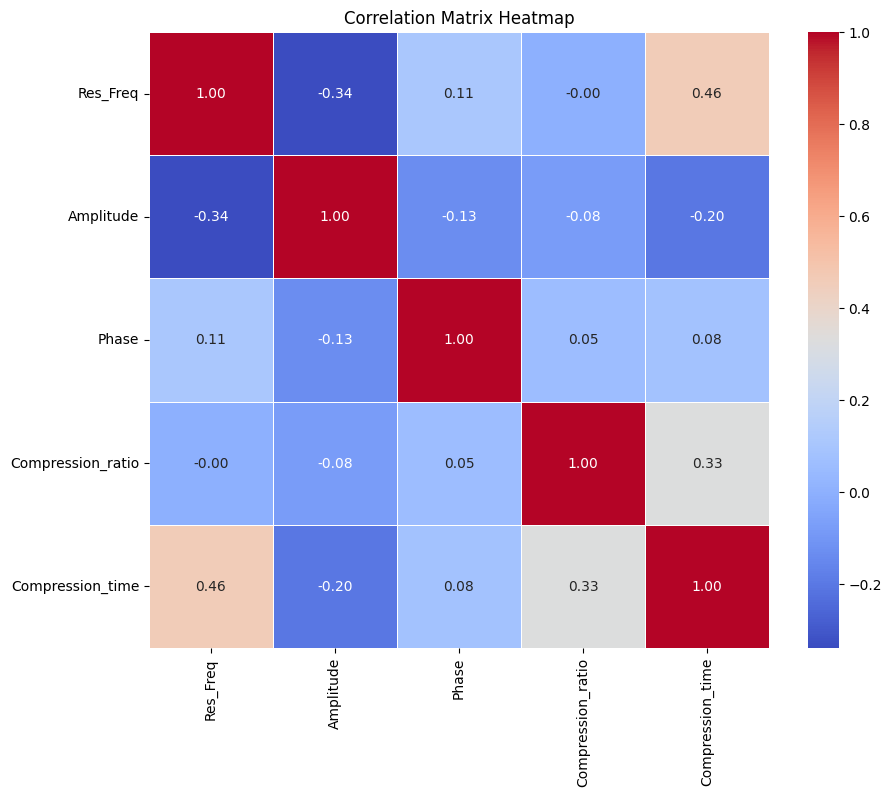

In [10]:
df = reload_df()

selected_features = ["Res_Freq", "Amplitude", "Phase", "Compression_ratio", "Compression_time"]
heatmap_data = df[selected_features]

# Calculate the correlation matrix
correlation_matrix = heatmap_data.corr()

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()





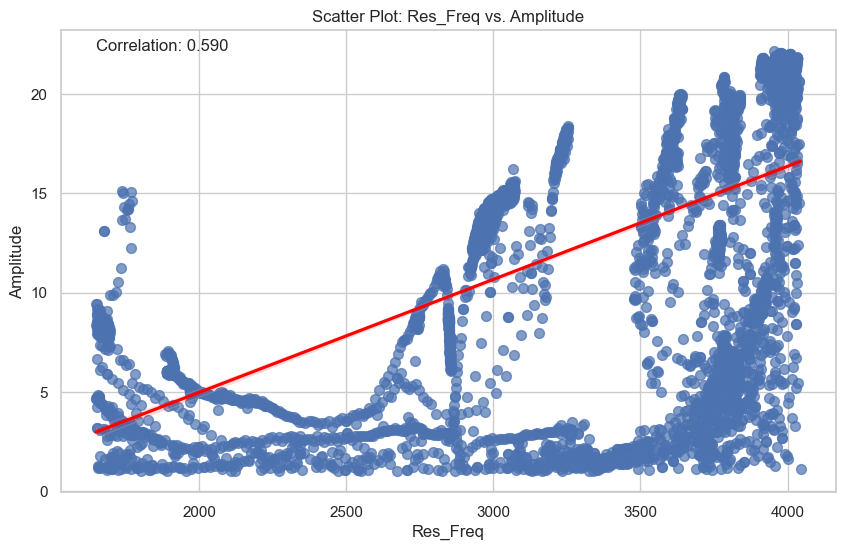

In [11]:
df = reload_df(3)
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.regplot(x='Res_Freq', y='Amplitude', data=df, scatter_kws={'s': 50, 'alpha': 0.7}, line_kws={'color': 'red'})
plt.xlabel('Res_Freq')
plt.ylabel('Amplitude')

plt.title('Scatter Plot: Res_Freq vs. Amplitude')
plt.text(df['Res_Freq'].min(), df['Amplitude'].max(), f'Correlation: {df.corr().loc["Res_Freq", "Amplitude"]:.3f}', fontsize=12)
plt.grid(True)
plt.show()






In [12]:
df = reload_df()
# sns.pairplot(df)
# plt.show()

# Heatmap to visualize the correlation between the features


# # Bar plot to visualize the mean of "Res_Freq" by category of "Compression_ratio"
# sns.barplot(x="Compression_ratio", y="Res_Freq", data=df)
# plt.title("Average Resonant Frequency by Compression Ratio")
# plt.show()

# # Box plot to visualize the distribution of "Amplitude" by category of "Res_Freq"
# sns.boxplot(x="Res_Freq", y="Amplitude", data=df)
# plt.title("Distribution of Amplitude by Resonant Frequency")
# plt.show()

c:\Users\Weyrd\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


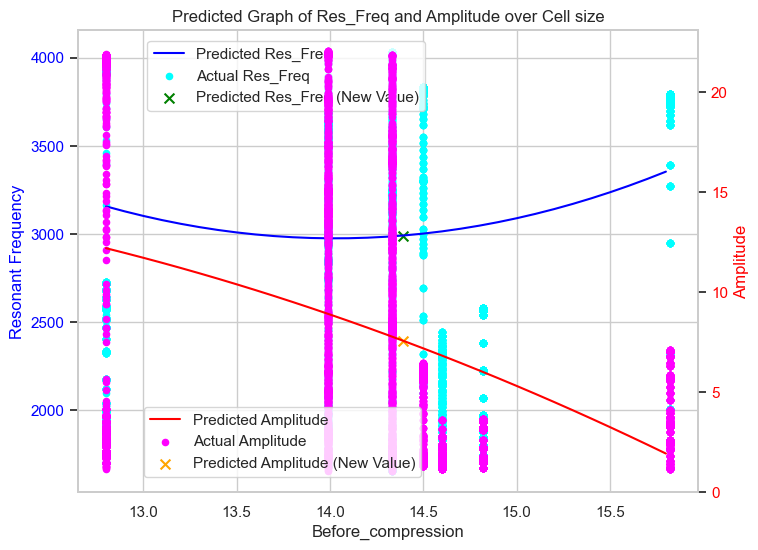

In [13]:
df = reload_df(2)

# Select the features and target
X = df[["Before_compression"]]
y_res_freq = df["Res_Freq"]
y_amplitude = df["Amplitude"]

# drop dna
X = X.dropna()
y_res_freq = y_res_freq.dropna()
y_amplitude = y_amplitude.dropna()

# Train the model on the entire dataset
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model_res_freq = LinearRegression()
model_res_freq.fit(X_poly, y_res_freq)

model_amplitude = LinearRegression()
model_amplitude.fit(X_poly, y_amplitude)

# Generate a range of "Before_compression" values for prediction
min_before_compression = df["Before_compression"].min()
max_before_compression = df["Before_compression"].max()
step_size = 0.1
before_compression_range = np.arange(min_before_compression, max_before_compression, step_size)

# Transform the range of values using PolynomialFeatures
before_compression_range_poly = poly.transform(before_compression_range.reshape(-1, 1))

# Make predictions for Res_Freq and Amplitude using the model for the entire range
predicted_res_freq_range = model_res_freq.predict(before_compression_range_poly)
predicted_amplitude_range = model_amplitude.predict(before_compression_range_poly)
new_data = pd.DataFrame({"Before_compression": [14.39]})

# Transform the new data using PolynomialFeatures
new_data_poly = poly.transform(new_data)

# Make the prediction using the loaded model for Res_Freq and Amplitude
predicted_res_freq = model_res_freq.predict(new_data_poly)
predicted_amplitude = model_amplitude.predict(new_data_poly)


# Plot the predicted graph with two legends on each side
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()


# Plot Amplitude on the second y-axis (right side)
color2 = 'red'
ax2.set_ylabel('Amplitude', color=color2)
ax2.plot(before_compression_range, predicted_amplitude_range, label='Predicted Amplitude', color=color2)
ax2.scatter(X, y_amplitude, label='Actual Amplitude', color='magenta', marker='o', s=20)

# Plot Res_Freq on the first y-axis (left side)
color1 = 'blue'
ax1.set_xlabel('Before_compression')
ax1.set_ylabel('Resonant Frequency', color=color1)
ax1.plot(before_compression_range, predicted_res_freq_range, label='Predicted Res_Freq', color=color1)
ax1.scatter(X, y_res_freq, label='Actual Res_Freq', color='cyan', marker='o', s=20)
ax1.scatter(new_data, predicted_res_freq, label='Predicted Res_Freq (New Value)', color='green', marker='x', s=50)

ax1.tick_params(axis='y', labelcolor=color1)


# Create a second y-axis for Amplitude (right side)

ax2.scatter(new_data, predicted_amplitude, label='Predicted Amplitude (New Value)', color='orange', marker='x', s=50)
ax2.tick_params(axis='y', labelcolor=color2)
# legend at 10% left
ax1.legend(loc='center left', bbox_to_anchor=(0.1, 0.9))
# below
ax2.legend(loc='upper center', bbox_to_anchor=(0.33, 0.2))


plt.title('Predicted Graph of Res_Freq and Amplitude over Cell size')
plt.grid()
plt.show()

c:\Users\Weyrd\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


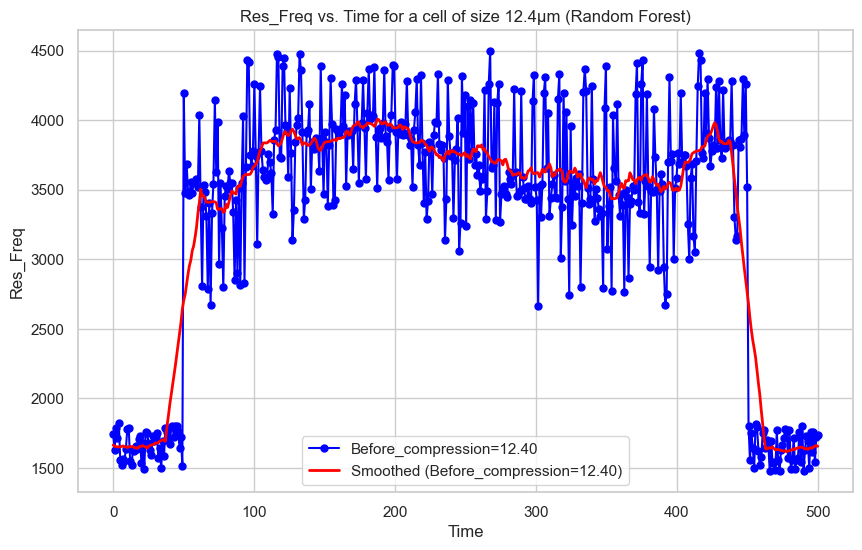

In [18]:

df = reload_df(2)

size_cell_pred = 12.4

max_time = 500


# Step 2: Choose the features and target variable
# only take Sample_number = 1
#df = df[df['Sample_number'] == 2]
Dt = Data()
X = df[['Time', 'Before_compression']]
y = df['Res_Freq']

# delete nan values
X = X.dropna()
y = y.dropna()


# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Step 4: Train the model (using Random Forest in this example)
model = RandomForestRegressor(n_estimators=100, random_state=2)
model.fit(X_train, y_train)

# Step 5: Save the model to a file
model_filename = 'data_/models/res_freq_prediction_model_rf.pkl'
joblib.dump(model, model_filename)

# Step 6: Generate points over time with different Before_compression values
# Replace 'before_compression_values' with the specific values you want to use


  # Replace this value with the specific value you want to use
before_compression_values = np.linspace(size_cell_pred, size_cell_pred, num=1)
time_values = np.linspace(0, max_time, num=500)

# Initialize an empty list to store the generated points
points_over_time = []

for before_compression in before_compression_values:
    X_new = np.column_stack((time_values, np.full_like(time_values, before_compression)))
    res_freq_predictions = model.predict(X_new)
    res_freq_predictions+=Dt.check()

    points_over_time.append((time_values, res_freq_predictions))


if y.name == 'Res_Freq':
  for i in Dt.maxVal(max_time, 0.9):
      if Dt._get_random_data(-1) < 0.4:
          res_freq_predictions[-i-1] = Dt._reprc_(0)
      else:
        res_freq_predictions[-i-1] = Dt._reprc_(1)


  for i in Dt.maxVal(max_time, 0.9):
      if Dt._get_random_data(-1) < 0.4:
          res_freq_predictions[i] = Dt._reprc_(0)
      else:
        res_freq_predictions[i] = Dt._reprc_(1)

# Step 7: Plot the graph for each Before_compression value


plt.figure(figsize=(10, 6))

for time_values, res_freq_predictions in points_over_time:
   
    # Calculate the rolling average using a larger window size, e.g., window=15
    rolling_avg = pd.Series(res_freq_predictions).rolling(window=25, min_periods=1, center=True).mean()
    
    # Compute the Z-score for each point in the smoothed curve
    z_scores = zscore(rolling_avg)
    
    # Define a threshold to identify outliers (e.g., z_score_threshold = 3.0)
    z_score_threshold = 3.0
    
    # Remove outliers from the smoothed curve
    rolling_avg_filtered = rolling_avg.copy()
    rolling_avg_filtered[np.abs(z_scores) > z_score_threshold] = np.nan
    
    mask = np.array(res_freq_predictions) >= 1000
    
    # Plot the original data points as a line plot with markers
    plt.plot(time_values[mask], res_freq_predictions[mask], label=f'Before_compression={before_compression:.2f}', color='blue', marker='o', markersize=5)
    
    # Plot the smoothed curve for valid data points
    plt.plot(time_values[mask], rolling_avg_filtered[mask], label=f'Smoothed (Before_compression={before_compression:.2f})', linewidth=2, color='red')

plt.xlabel('Time')
plt.ylabel('Res_Freq')
plt.title(f'Res_Freq vs. Time for a cell of size {size_cell_pred}μm (Random Forest)')
plt.legend()
plt.show()

